Copy the files **spy.train.csv.gz** and **spy.test.csv.gz** located in https://github.com/crapher/medium/tree/main/08.GABBStrategy/data to your colab folder

In [1]:
# !pip install pandas_ta tqdm pygad

In [2]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import pygad

from tqdm import tqdm


In [3]:
# Constants
CASH = 100
SOLUTIONS = 30
GENERATIONS = 30
TRAIN_FILE = '../data/spy.train.csv.gz'
TEST_FILE = '../data/spy.test.csv.gz'

In [4]:
# Configuration
np.set_printoptions(suppress=True)
pd.options.mode.chained_assignment = None

In [5]:
# Loading data, and split in train and test datasets
def get_data():

    train = pd.read_csv(TRAIN_FILE, compression='gzip')
    train.ta.bbands(close=train['close'], length=10, append=True)
    train = train.dropna()
    train['high_limit'] = train['BBU_10_2.0'] + (train['BBU_10_2.0'] - train['BBL_10_2.0']) / 2
    train['low_limit'] = train['BBL_10_2.0'] - (train['BBU_10_2.0'] - train['BBL_10_2.0']) / 2
    train['close_percentage'] = np.clip((train['close'] - train['low_limit']) / (train['high_limit'] - train['low_limit']), 0, 1)
    train['bandwidth'] = np.clip(train['BBB_10_2.0'] / 100, 0, 1)

    test = pd.read_csv(TEST_FILE, compression='gzip')
    test.ta.bbands(close=test['close'], length=10, append=True)
    test = test.dropna()
    test['high_limit'] = test['BBU_10_2.0'] + (test['BBU_10_2.0'] - test['BBL_10_2.0']) / 2
    test['low_limit'] = test['BBL_10_2.0'] - (test['BBU_10_2.0'] - test['BBL_10_2.0']) / 2
    test['close_percentage'] = np.clip((test['close'] - test['low_limit']) / (test['high_limit'] - test['low_limit']), 0, 1)
    test['bandwidth'] = np.clip(test['BBB_10_2.0'] / 100, 0, 1)

    return train, test

In [6]:
# Define fitness function to be used by the PyGAD instance
def fitness_func(self, solution, sol_idx):

    # Get Reward from train data
    total_reward, _, _ , _= get_result(train, solution[0], solution[1], solution[2])
    # print(total_reward)
    # Return the solution reward
    return total_reward

In [7]:
# Define a reward function
def get_result(df, min_bandwidth, max_buy_perc, min_sell_perc):

    # Generate a copy to avoid changing the original data
    df = df.copy().reset_index(drop=True)

    # Buy Signal
    df['signal'] = np.where((df['bandwidth'] > min_bandwidth) & (df['close_percentage'] < max_buy_perc), 1, 0)

    # Sell Signal
    df['signal'] = np.where((df['close_percentage'] > min_sell_perc), -1, df['signal'])

    # Remove all rows without operations, rows with the same consecutive operation, first row selling, and last row buying
    result = df[df['signal'] != 0]
    result = result[result['signal'] != result['signal'].shift()]
    if (len(result) > 0) and (result.iat[0, -1] == -1): result = result.iloc[1:]
    if (len(result) > 0) and (result.iat[-1, -1] == 1): result = result.iloc[:-1]

    # Calculate the reward / operation
    result['total_reward'] = np.where(result['signal'] == -1, ((result['close'] - result['close'].shift()) * (CASH / result['close'].shift()))- CASH*0.0002, 0)

    # Generate the result
    total_reward = result['total_reward'].sum()
    wins = len(result[result['total_reward'] > 0])
    losses = len(result[result['total_reward'] < 0])

    return total_reward, wins, losses, result

* his data

In [21]:
# Get Train and Test data
# train, test = get_data()

* Real Data

In [20]:
data = pd.read_csv('/Users/kiril/Documents/GitHub/NTC/Collected Data/test/corrected/almost_all_data.csv')
data = data[['index','Adj_SPY']]
data.rename(columns={'Adj_SPY':'close', 'index':'date'}, inplace=True)
data

,date,close
0,2022-06-01 09:30:00,415.589996
1,2022-06-01 09:31:00,415.869995
2,2022-06-01 09:32:00,415.704803
3,2022-06-01 09:33:00,415.390015
4,2022-06-01 09:34:00,415.570007
...,...,...
229914,2021-10-05 15:55:00,433.260010
229915,2021-10-05 15:56:00,433.329987
229916,2021-10-05 15:57:00,433.579987
229917,2021-10-05 15:58:00,433.260010


In [18]:
train

,date,close
0,2008-01-22 09:35:00,127.65
1,2008-01-22 09:40:00,128.10
2,2008-01-22 09:45:00,129.03
3,2008-01-22 09:50:00,129.25
4,2008-01-22 09:55:00,128.53
...,...,...
286553,2021-05-06 15:35:00,417.68
286554,2021-05-06 15:40:00,417.79
286555,2021-05-06 15:45:00,418.05
286556,2021-05-06 15:50:00,418.56


In [9]:
# Process data
print("".center(60, "*"))
print(f' PROCESSING DATA '.center(60, '*'))
print("".center(60, "*"))

with tqdm(total=GENERATIONS) as pbar:

    # Create Genetic Algorithm
    ga_instance = pygad.GA(num_generations=GENERATIONS,
                           num_parents_mating=5,
                           fitness_func=fitness_func,
                           sol_per_pop=SOLUTIONS,
                           num_genes=3,
                           gene_space=[
                            {'low': 0, 'high': 1},
                            {'low': 0, 'high': 1, 'step': 0.01},
                            {'low': 0, 'high': 1, 'step': 0.01}],
                           parent_selection_type="sss",
                           crossover_type="single_point",
                           mutation_type="random",
                           mutation_num_genes=1,
                           keep_parents=-1,
                           random_seed=42,
                           on_generation=lambda _: pbar.update(1),
                           )

    # Run the Genetic Algorithm
    ga_instance.run()

************************************************************
********************* PROCESSING DATA **********************
************************************************************


100%|██████████| 30/30 [00:12<00:00,  2.38it/s]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


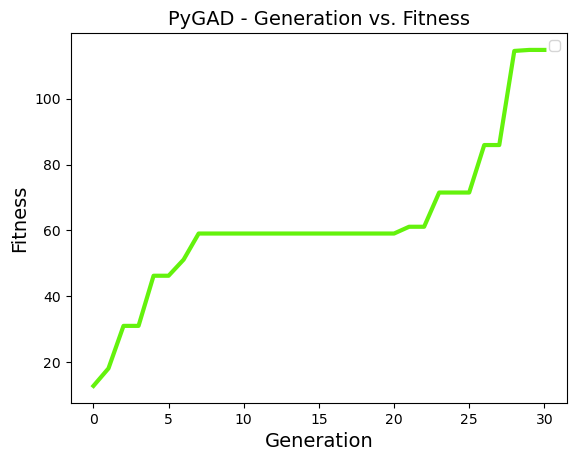

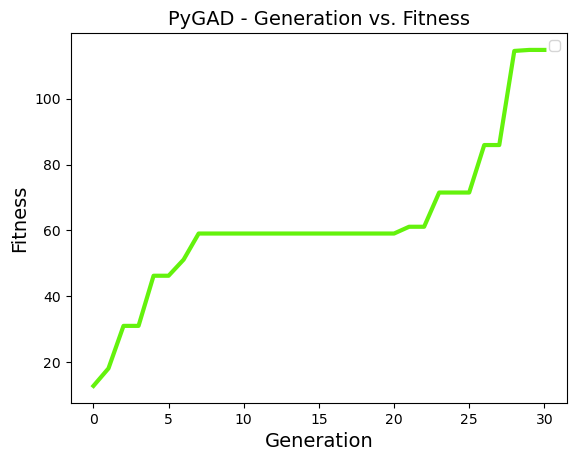

In [10]:
ga_instance.plot_fitness()


In [11]:
# Show details of the best solution.
solution, solution_fitness, _ = ga_instance.best_solution()

print(f' Best Solution Parameters '.center(60, '*'))
print(f"Min Bandwidth    : {solution[0]:6.4f}")
print(f"Max Perc to Buy  : {solution[1]:6.2f}")
print(f"Min Perc to Sell : {solution[2]:6.2f}")

# Get Reward from train data
profit, wins, losses, result = get_result(train, solution[0], solution[1], solution[2])

print(f' Result (TRAIN) '.center(60, '*'))
print(f"* Profit / Loss  : {profit:.2f}")
print(f"* Wins / Losses  : {wins} / {losses}")
print(f"* Win Rate       : {(100 * (wins/(wins + losses)) if wins + losses > 0 else 0):.2f}%")

# Get Reward from test data
profit, wins, losses, result2 = get_result(test, solution[0], solution[1], solution[2])

# Show the final result
print(f' Result (TEST) '.center(60, '*'))
print(f"* Profit / Loss  : {profit:.2f}")
print(f"* Wins / Losses  : {wins} / {losses}")
print(f"* Win Rate       : {(100 * (wins/(wins + losses)) if wins + losses > 0 else 0):.2f}%")

***************** Best Solution Parameters *****************
Min Bandwidth    : 0.0010
Max Perc to Buy  :   0.94
Min Perc to Sell :   0.87
********************** Result (TRAIN) **********************
* Profit / Loss  : 114.81
* Wins / Losses  : 73 / 23
* Win Rate       : 76.04%
********************** Result (TEST) ***********************
* Profit / Loss  : -2.37
* Wins / Losses  : 3 / 3
* Win Rate       : 50.00%


In [12]:
result2

,date,close,BBL_10_2.0,BBM_10_2.0,BBU_10_2.0,BBB_10_2.0,BBP_10_2.0,high_limit,low_limit,close_percentage,bandwidth,signal,total_reward
0,2021-06-14 10:20:00,423.555,423.358970,423.75500,424.151030,0.186915,0.247494,424.547061,422.962939,0.373747,0.001869,1,0.000000
2174,2021-07-23 09:30:00,437.480,434.361656,435.61745,436.873244,0.576558,1.241583,438.129038,433.105862,0.870791,0.005766,-1,3.267649
2175,2021-07-23 09:35:00,437.150,434.225094,435.77795,437.330806,0.712682,0.941783,438.883662,432.672238,0.720891,0.007127,1,0.000000
9551,2021-12-07 09:30:00,464.880,456.174986,459.67650,463.178014,1.523469,1.243036,466.679528,452.673472,0.871518,0.015235,-1,6.323360
9552,2021-12-07 09:35:00,465.080,455.459320,460.22650,464.993680,2.071667,1.009054,469.760859,450.692141,0.754527,0.020717,1,0.000000
14855,2022-03-16 09:30:00,430.610,423.577634,426.40220,429.226766,1.324837,1.244858,432.051332,420.753068,0.872429,0.013248,-1,-7.431628
14856,2022-03-16 09:35:00,431.820,422.789336,427.02320,431.257064,1.982967,1.066480,435.490927,418.555473,0.783240,0.019830,1,0.000000
22733,2022-08-10 09:30:00,417.820,408.032301,411.95651,415.880719,1.905157,1.247092,419.804928,404.108092,0.873546,0.019052,-1,-3.262092
22734,2022-08-10 09:35:00,417.300,407.552032,412.56451,417.576988,2.429912,0.972370,422.589466,402.539554,0.736185,0.024299,1,0.000000
26477,2022-10-18 09:30:00,374.305,363.405322,367.78096,372.156598,2.379481,1.245496,376.532237,359.029683,0.872748,0.023795,-1,-10.323139
